# DSLab Homework 1 - Data Science with CO2

## Hand-in Instructions

- __Due: 23.03.2021 23h59 CET__
- `git push` your final verion to the master branch of your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Carbosense

The project Carbosense establishes a uniquely dense CO2 sensor network across Switzerland to provide near-real time information on man-made emissions and CO2 uptake by the biosphere. The main goal of the project is to improve the understanding of the small-scale CO2 fluxes in Switzerland and concurrently to contribute to a better top-down quantification of the Swiss CO2 emissions. The Carbosense network has a spatial focus on the City of Zurich where more than 50 sensors are deployed. Network operations started in July 2017.

<img src="http://carbosense.wdfiles.com/local--files/main:project/CarboSense_MAP_20191113_LowRes.jpg" width="500">

<img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_ZLMT_3.JPG" width="156">  <img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_sensor_SMALL.jpg" width="300">

## Description of the homework

In this homework, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich from the Carbosense project. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city **zones** and the zone in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

## Prior knowledge

The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains, forests), are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. **The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.** 

## To start with

The following csv files in the `../data/carbosense-raw/` folder will be needed: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements `CO2`, the name of the site `LocationName`, a unique sensor identifier `SensorUnit_ID`, and the time instance in which the measurement was taken `timestamp`.
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp `Timestamp`. For each `SensorUnit_ID`, the temperature and the humidity can be found in the corresponding columns of the dataframe `{SensorUnit_ID}.temperature`, `{SensorUnit_ID}.humidity`.
    
3. `sensor_metadata.csv`

   __Description__: It contains the name of the site `LocationName`, the zone index `zone`, the altitude in meters `altitude`, the longitude `lon`, and the latitude `lat`. 

Import the following python packages:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import LinearRegression

In [2]:
pd.options.mode.chained_assignment = None

## PART I: Handling time series with pandas (10 points)

### a) **8/10**

Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe. 

* The merged dataframe contains:
    - index: the time instance `timestamp` of the measurements
    - columns: the location of the site `LocationName`, the sensor ID `SensorUnit_ID`, the CO2 measurement `CO2`, the `temperature`, the `humidity`, the `zone`, the `altitude`, the longitude `lon` and the latitude `lat`.

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |



* For each measurement (CO2, humidity, temperature), __take the average over an interval of 30 min__. 

* If there are missing measurements, __interpolate them linearly__ from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [3]:
!git lfs pull

In [4]:
co2_measurements = pd.read_csv("../data/carbosense-raw/CO2_sensor_measurements.csv",
                                sep="\t",
                                parse_dates=['timestamp'])
# rename for consistency of column names accross the dataframes
co2_measurements = co2_measurements.rename({'SensorUnit_ID':'sensor'}, axis=1)

In [5]:
co2_measurements.head()

timestamp LocationName  sensor         CO2
0 2017-10-01 00:05:00         ZGHD    1014  593.321562
1 2017-10-01 00:15:00         ZGHD    1014  595.846258
2 2017-10-01 00:25:00         ZGHD    1014  595.845353
3 2017-10-01 00:45:00         ZGHD    1014  599.039129
4 2017-10-01 00:55:00         ZGHD    1014  594.996629

In [6]:
co2_measurements[co2_measurements.LocationName == "ZHRO"]

timestamp LocationName  sensor         CO2
100100 2017-10-19 13:44:00         ZHRO    1117  435.517352
100101 2017-10-19 13:54:00         ZHRO    1117  431.920620
100102 2017-10-19 14:04:00         ZHRO    1117  433.222353
100103 2017-10-19 14:14:00         ZHRO    1117  427.284986
100104 2017-10-19 14:24:00         ZHRO    1117  431.055325
...                    ...          ...     ...         ...
101686 2017-10-31 23:04:00         ZHRO    1117  487.892983
101687 2017-10-31 23:24:00         ZHRO    1117  486.393620
101688 2017-10-31 23:34:00         ZHRO    1117  494.001575
101689 2017-10-31 23:44:00         ZHRO    1117  484.290109
101690 2017-10-31 23:54:00         ZHRO    1117  482.339393

[1591 rows x 4 columns]

In [7]:
co2_measurements.isnull().any(None) # verify null values

False

In [8]:
co2_measurements['sensor'] = co2_measurements['sensor'].astype(int)

In [9]:
# function to resample the C02 measurements dataframe
def co2_measurements_resample(df):
    res = df['CO2'].resample('30min').mean().to_frame()
    # Some periods of 30min have 0 datapoints, therefore we need to interpolate
    res = res.interpolate('linear', axis=0)
    # save the location name for each sensor
    res['LocationName'] = df['LocationName'].values[0]
    return res

co2_measurements = co2_measurements.set_index('timestamp') \
                                   .groupby('sensor') \
                                   .apply(co2_measurements_resample)

In [10]:
co2_measurements.groupby("LocationName").count()

CO2
LocationName      
AJGR          1488
BSCR          1488
BUDF          1488
KBRL          1488
KTGM          1488
RCTZ          1488
SMHK          1488
SZGL          1488
ULGW          1488
UTLI          1488
WMOO          1488
WRTW          1488
WSUM          1488
ZALL          1488
ZAML          1488
ZAZG          1488
ZBLG          1488
ZBRC          1488
ZDLT          1488
ZECB          1488
ZFBL          1488
ZFHB          1488
ZFRK          1488
ZGHD          1488
ZHBG          1488
ZHBR          1488
ZHRG          1488
ZHRO           597
ZHRZ          1488
ZLDW          1488
ZLMT          1488
ZNEU          1488
ZORL          1488
ZPFW           598
ZPRD          1488
ZRDH          1488
ZSBN          1488
ZSCH          1488
ZSEF          1488
ZSTA          1488
ZSTL          1488
ZSZW          1488
ZTBN          1488
ZUBG          1488
ZUE           1488
ZWCH          1488

In [11]:
co2_measurements.isnull().any(None)

False

In [12]:
temp_humidity = pd.read_csv("../data/carbosense-raw/temperature_humidity.csv",
                            sep="\t",
                            parse_dates=['Timestamp'])
# rename for consistency of column names accross the dataframes
temp_humidity = temp_humidity.rename({'Timestamp':'timestamp'}, axis=1)

In [13]:
temp_humidity.head()

timestamp  1014.temperature  1014.humidity  1015.temperature  \
0 2017-10-01 00:00:00             11.39      92.262787             10.55   
1 2017-10-01 00:10:00             11.39      92.579407             10.48   
2 2017-10-01 00:20:00             11.41      92.480225             10.51   
3 2017-10-01 00:30:00             11.35      91.902298             10.55   
4 2017-10-01 00:40:00             11.30      91.639084             10.59   

   1015.humidity  1016.temperature  1016.humidity  1017.temperature  \
0      91.949982             11.02      92.613739             11.05   
1      92.079681             11.04      93.063873             11.05   
2      92.583221             11.06      93.201202             11.02   
3      92.714828             11.02      92.932266             10.96   
4      92.764420             10.99      92.598480             10.95   

   1017.humidity  1018.temperature  ...  1291.temperature  1291.humidity  \
0      89.811844             11.38  ...             10.13      96.828979   
1      90.042633             11.38  ...             10.12      97.322983   
2      89.888138             11.35  ...             10.14      97.780746   
3      89.790863             11.31  ...             10.13      97.904724   
4      89.821381             11.27  ...             10.13      97.931427   

   1292.temperature  1292.humidity  1297.temperature  1297.humidity  \
0             10.50      95.858139             10.70      94.524902   
1             10.45      95.903915             10.53      94.395203   
2             10.43      95.343155             10.45      94.620270   
3             10.43      95.322174             10.42      94.973129   
4             10.48      96.451324             10.46      95.282120   

   1298.temperature  1298.humidity  1299.temperature  1299.humidity  
0             11.35      90.288681             11.44      90.118927  
1             11.35      90.422195             11.46      90.073151  
2             11.33      91.023010             11.41      89.466614  
3             11.32      91.019196             11.39      89.249176  
4             11.28      90.443176             11.31      88.871521  

[5 rows x 93 columns]

In [14]:
# Melt the dataframe into long format keeping only the timestamp
temp_humidity = pd.melt(temp_humidity, id_vars='timestamp', var_name='sensor.temp_humidity', value_name='measurement')
# split the Var column to get the sensor ID and the column name in seperate columns
temp_humidity[['sensor','temp_humidity']] = temp_humidity['sensor.temp_humidity'].str.split('.', expand=True)
# Finally pivot the dataframe to get it in a desired format
temp_humidity = temp_humidity.pivot(index=['timestamp','sensor'], columns='temp_humidity', values='measurement').reset_index()

In [15]:
temp_humidity

temp_humidity           timestamp sensor   humidity  temperature
0             2017-10-01 00:00:00   1014  92.262787        11.39
1             2017-10-01 00:00:00   1015  91.949982        10.55
2             2017-10-01 00:00:00   1016  92.613739        11.02
3             2017-10-01 00:00:00   1017  89.811844        11.05
4             2017-10-01 00:00:00   1018  91.427368        11.38
...                           ...    ...        ...          ...
205339        2017-10-31 23:50:00   1291  94.849152         1.96
205340        2017-10-31 23:50:00   1292  96.170944        -0.54
205341        2017-10-31 23:50:00   1297  94.997925         0.05
205342        2017-10-31 23:50:00   1298  83.046478         2.82
205343        2017-10-31 23:50:00   1299  82.041306         3.22

[205344 rows x 4 columns]

In [16]:
temp_humidity['sensor'] = temp_humidity['sensor'].astype(int)

In [17]:
temp_humidity.isnull().any(None)

True

In [18]:
# resample the temperature humidity dataframe every 30 min
temp_humidity = temp_humidity.set_index('timestamp') \
                             .groupby('sensor') \
                             .apply(lambda df: df[['temperature', 'humidity']]
                                               .interpolate('linear', axis=0) \
                                               .resample('30min').mean())

In [19]:
temp_humidity.isnull().any(None)

False

In [20]:
temp_humidity

temp_humidity               temperature   humidity
sensor timestamp                                  
1014   2017-10-01 00:00:00    11.396667  92.440806
       2017-10-01 00:30:00    11.303333  91.625097
       2017-10-01 01:00:00    11.240000  91.096761
       2017-10-01 01:30:00    11.260000  91.275734
       2017-10-01 02:00:00    11.285000  91.003937
...                                 ...        ...
1299   2017-10-31 21:30:00     3.923333  78.965388
       2017-10-31 22:00:00     3.766667  79.702896
       2017-10-31 22:30:00     3.493333  80.769740
       2017-10-31 23:00:00     3.373333  81.676366
       2017-10-31 23:30:00     3.286667  81.910970

[68448 rows x 2 columns]

In [21]:
metadata = pd.read_csv("../data/carbosense-raw/sensors_metadata.csv", sep="\t")

In [22]:
metadata.head()

LocationName  zone  altitude       lat       lon
0         AJGR     2     627.8  47.33321  8.480300
1         BSCR     2     462.3  47.35581  8.430070
2         BUDF    10     490.2  47.36270  8.433110
3         KBRL     7     510.5  47.32582  8.537550
4         KTGM     2     530.3  47.32334  8.596422

In [23]:
# merge all three dataframes together
temp_humidity = temp_humidity.reset_index()
co2_measurements = co2_measurements.reset_index()
final_df = pd.merge(temp_humidity, co2_measurements, how='inner', right_on=['sensor','timestamp'], left_on=['sensor','timestamp'])
final_df = pd.merge(final_df, metadata, left_on='LocationName', right_on='LocationName', validate='m:1')

In [24]:
final_df.isnull().any(None)

False

In [25]:
final_df = final_df.set_index('timestamp')

### b) **2/10** 

Export the curated and ready to use timeseries to a csv file, and properly push the merged csv to Git LFS.

In [ ]:
os.chdir('..')

In [ ]:
!git lfs track -l 

In [ ]:
save_path = 'data/carbosense-raw/final_df.csv'

In [ ]:
!git lfs track data/carbosense-raw/final_df.csv

In [ ]:
!git lfs track -l 

In [ ]:
final_df.to_csv(save_path, sep='\t')

In [ ]:
# !git add  data/carbosense-raw/final_df.csv

In [ ]:
# !git commit -m "df csv file"

In [ ]:
# !git push

In [ ]:
os.chdir('notebooks')

## PART II: Data visualization (15 points)

### a) **5/15** 
Group the sites based on their altitude, by performing K-means clustering. 
- Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
- Wite out the formula of metric you use for Elbow curve. 
- Perform clustering with the optimal number of clusters and add an additional column `altitude_cluster` to the dataframe of the previous question indicating the altitude cluster index. 
- Report your findings.

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [27]:
metadata

LocationName  zone  altitude        lat       lon
0          AJGR     2     627.8  47.333210  8.480300
1          BSCR     2     462.3  47.355810  8.430070
2          BUDF    10     490.2  47.362700  8.433110
3          KBRL     7     510.5  47.325820  8.537550
4          KTGM     2     530.3  47.323340  8.596422
5          RCTZ     7     440.9  47.434277  8.506933
6          SMHK     2     404.4  47.394410  8.445830
7          SZGL     2     391.9  47.405815  8.445361
8          ULGW     6     627.1  47.357480  8.469090
9          UTLI    10     863.6  47.351406  8.490318
10         WMOO     4     526.3  47.336250  8.461950
11         WRTW     2     451.4  47.418366  8.603844
12         WSUM    10     424.7  47.419728  8.430176
13         ZALL     5     422.7  47.353400  8.524100
14         ZAML     2     445.5  47.424093  8.507078
15         ZAZG     2     430.6  47.413577  8.572150
16         ZBLG     2     410.7  47.378930  8.512590
17         ZBRC     2     436.0  47.425955  8.542861
18         ZDLT     5     448.4  47.365820  8.503600
19         ZECB     2     406.8  47.383200  8.509864
20         ZFBL     5     443.4  47.428260  8.550420
21         ZFHB     8     518.5  47.395000  8.551740
22         ZFRK     2     442.0  47.409757  8.543918
23         ZGHD     2     413.5  47.370446  8.523256
24         ZHBG    10     683.9  47.385994  8.568091
25         ZHBR     2     615.8  47.381580  8.566050
26         ZHRG     3     410.5  47.377773  8.519460
27         ZHRO     2     397.6  47.393940  8.486670
28         ZHRZ     3     429.5  47.403596  8.587764
29         ZLDW     5     405.9  47.348870  8.536290
30         ZLMT    14     407.8  47.369230  8.543280
31         ZNEU     2     404.7  47.384587  8.525195
32         ZORL     5     439.9  47.414780  8.537913
33         ZPFW     1     402.5  47.388045  8.513577
34         ZPRD     2     409.7  47.370224  8.538994
35         ZRDH     3     470.0  47.418554  8.511709
36         ZSBN     3     415.4  47.385835  8.477908
37         ZSCH     2     413.1  47.370983  8.523569
38         ZSEF     2     415.1  47.357170  8.555190
39         ZSTA     2     420.8  47.386741  8.539785
40         ZSTL     2     430.8  47.408340  8.563520
41         ZSZW     7     602.2  47.382488  8.590823
42         ZTBN     2     402.9  47.389721  8.517753
43         ZUBG     3     480.7  47.352860  8.511080
44          ZUE     3     408.8  47.377576  8.530397
45         ZWCH     2     450.0  47.343030  8.527060

In [28]:
site_data= metadata[['LocationName', 'altitude', 'lat', 'lon']]

In [29]:
# extracting altitude values of the sites 
X= site_data.altitude.values.reshape(-1,1)

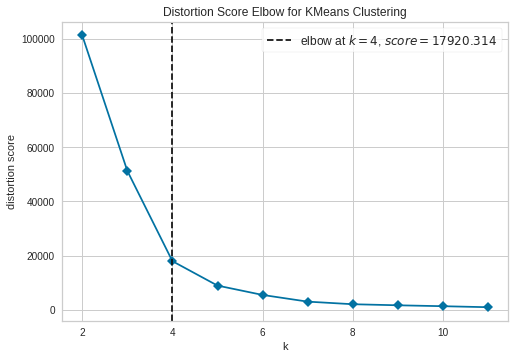

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
# Here we use the Elbow method to choose the optimal number of clusters
# We use KElbowVisualizer from Yelloybrick library to fit the model with different K values and choose the most optimal
model= KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings = False, metric= "distortion")
visualizer.fit(X)
visualizer.show()

In [32]:
# From the visualization in the previous cell, the optimal k by the elbow method is 4
optimal_k = visualizer.elbow_value_

### Metric used in the Elbow curve: mean Distortion 

We use here the mean distortion metric or the within-cluster sum of squares  i.e the mean of the square distances of each points from the center of the cluster assigned to it.

mean  distortion $= \frac{1}{N} * \sum_{k=1}^{K} \sum_{x\in {S_k}} (x- \mu_k)^{2}
$

where $\mu_k$ denotes the mean of the altitudes in the cluster k

In [34]:
# We fit the model with the optimal number of clusters
model = KMeans(n_clusters= optimal_k)
model.fit(X)

KMeans(n_clusters=4)

In [35]:
# we add the assigned cluster index to the dataframe
assigned_clusters = model.labels_
site_data['altitude_cluster'] = assigned_clusters

In [36]:
site_data.head()

LocationName  altitude       lat       lon  altitude_cluster
0         AJGR     627.8  47.33321  8.480300                 1
1         BSCR     462.3  47.35581  8.430070                 3
2         BUDF     490.2  47.36270  8.433110                 3
3         KBRL     510.5  47.32582  8.537550                 3
4         KTGM     530.3  47.32334  8.596422                 3

In [37]:
# We add the altitude_cluster column to the dataframe 
final_df = pd.merge(final_df.reset_index(), site_data[["LocationName", "altitude_cluster"]], on= "LocationName").set_index("timestamp")

In [38]:
final_df

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-01 00:00:00    1014    11.396667  92.440806  595.004391         ZGHD   
2017-10-01 00:30:00    1014    11.303333  91.625097  597.017879         ZGHD   
2017-10-01 01:00:00    1014    11.240000  91.096761  596.487010         ZGHD   
2017-10-01 01:30:00    1014    11.260000  91.275734  598.787639         ZGHD   
2017-10-01 02:00:00    1014    11.285000  91.003937  595.366394         ZGHD   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1299     3.923333  78.965388  477.307329         ZLDW   
2017-10-31 22:00:00    1299     3.766667  79.702896  474.396830         ZLDW   
2017-10-31 22:30:00    1299     3.493333  80.769740  474.406102         ZLDW   
2017-10-31 23:00:00    1299     3.373333  81.676366  477.910252         ZLDW   
2017-10-31 23:30:00    1299     3.286667  81.910970  471.881151         ZLDW   

                     zone  altitude        lat       lon  altitude_cluster  
timestamp                                                                   
2017-10-01 00:00:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 00:30:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 01:00:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 01:30:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 02:00:00     2     413.5  47.370446  8.523256                 0  
...                   ...       ...        ...       ...               ...  
2017-10-31 21:30:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 22:00:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 22:30:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 23:00:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 23:30:00     5     405.9  47.348870  8.536290                 0  

[66667 rows x 10 columns]

### b) **4/15** 

Use `plotly` (or other similar graphing libraries) to create an interactive plot of the monthly median CO2 measurement for each site with respect to the altitude. 

Add proper title and necessary hover information to each point, and give the same color to stations that belong to the same altitude cluster.

In [41]:
median_df = co2_measurements.groupby(by='LocationName').median()

In [42]:
median_df = median_df.drop(columns= ["sensor"]).rename(columns= {"CO2" : "CO2_median"})

In [43]:
median_df

CO2_median
LocationName            
AJGR          334.785793
BSCR          474.502250
BUDF          422.793126
KBRL          410.100150
KTGM          444.395518
RCTZ          451.003079
SMHK          522.346787
SZGL          488.481426
ULGW          430.143296
UTLI          779.594440
WMOO          432.382187
WRTW          428.965858
WSUM          386.297648
ZALL          469.616355
ZAML          514.683942
ZAZG          448.988224
ZBLG          438.280143
ZBRC          438.016085
ZDLT          444.828444
ZECB          429.376849
ZFBL          467.144218
ZFHB          391.755015
ZFRK          467.852716
ZGHD          614.545051
ZHBG          406.154557
ZHBR          428.127696
ZHRG          439.161697
ZHRO          437.753069
ZHRZ          493.186651
ZLDW          425.401803
ZLMT          440.420556
ZNEU          459.149172
ZORL          481.059336
ZPFW          422.472054
ZPRD          439.426745
ZRDH          348.186164
ZSBN          417.820925
ZSCH          448.509612
ZSEF          450.205149
ZSTA          435.569305
ZSTL          494.296882
ZSZW          460.875583
ZTBN          466.948569
ZUBG          416.204517
ZUE           434.604078
ZWCH          450.098594

In [44]:
# We merge the two dataframes found
result = pd.merge(median_df, site_data, on= 'LocationName') 

# We change the altitude_cluster column type to str to have categorical colors in the plot
result["altitude_cluster"] = result["altitude_cluster"].astype(str)

In [45]:
result.head()

LocationName  CO2_median  altitude       lat       lon altitude_cluster
0         AJGR  334.785793     627.8  47.33321  8.480300                1
1         BSCR  474.502250     462.3  47.35581  8.430070                3
2         BUDF  422.793126     490.2  47.36270  8.433110                3
3         KBRL  410.100150     510.5  47.32582  8.537550                3
4         KTGM  444.395518     530.3  47.32334  8.596422                3

In [46]:
# we visualize the monthly median as a function of the altitude colored according to the clustering result
px.scatter(result, x= 'altitude', y= 'CO2_median', color= 'altitude_cluster', title= "Clustering of sensors by altitude", hover_name="LocationName")

### c) **6/15**

Use `plotly` (or other similar graphing libraries) to plot an interactive time-varying density heatmap of the mean daily CO2 concentration for all the stations. Add proper title and necessary hover information.

__Hints:__ Check following pages for more instructions:
- [Animations](https://plotly.com/python/animations/)
- [Density Heatmaps](https://plotly.com/python/mapbox-density-heatmaps/)

In [47]:
# We compute the mean daily CO2 measurements for each site 
daily_co2_measurements= co2_measurements.groupby(by = ["LocationName", co2_measurements['timestamp'].dt.day]).mean().drop(columns= ["sensor"]).reset_index()

In [48]:
daily_co2_measurements.head()

LocationName  timestamp         CO2
0         AJGR          1  336.656408
1         AJGR          2  342.793705
2         AJGR          3  335.531220
3         AJGR          4  335.316507
4         AJGR          5  340.486617

In [49]:
site_data.head()

LocationName  altitude       lat       lon  altitude_cluster
0         AJGR     627.8  47.33321  8.480300                 1
1         BSCR     462.3  47.35581  8.430070                 3
2         BUDF     490.2  47.36270  8.433110                 3
3         KBRL     510.5  47.32582  8.537550                 3
4         KTGM     530.3  47.32334  8.596422                 3

In [50]:
final_df[final_df.LocationName == "ZHRO"]

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-19 13:30:00    1117    22.680000  42.270543  433.718986         ZHRO   
2017-10-19 14:00:00    1117    22.903333  44.397237  430.520888         ZHRO   
2017-10-19 14:30:00    1117    20.746667  48.766337  425.265832         ZHRO   
2017-10-19 15:00:00    1117    19.850000  47.809484  432.520878         ZHRO   
2017-10-19 15:30:00    1117    19.476667  48.056168  435.753967         ZHRO   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1117     3.180000  84.997696  486.615584         ZHRO   
2017-10-31 22:00:00    1117     2.870000  86.240651  487.632920         ZHRO   
2017-10-31 22:30:00    1117     2.680000  87.258858  491.697517         ZHRO   
2017-10-31 23:00:00    1117     2.516667  87.853633  487.143302         ZHRO   
2017-10-31 23:30:00    1117     2.316667  88.916662  486.877026         ZHRO   

                     zone  altitude       lat      lon  altitude_cluster  
timestamp                                                                 
2017-10-19 13:30:00     2     397.6  47.39394  8.48667                 0  
2017-10-19 14:00:00     2     397.6  47.39394  8.48667                 0  
2017-10-19 14:30:00     2     397.6  47.39394  8.48667                 0  
2017-10-19 15:00:00     2     397.6  47.39394  8.48667                 0  
2017-10-19 15:30:00     2     397.6  47.39394  8.48667                 0  
...                   ...       ...       ...      ...               ...  
2017-10-31 21:30:00     2     397.6  47.39394  8.48667                 0  
2017-10-31 22:00:00     2     397.6  47.39394  8.48667                 0  
2017-10-31 22:30:00     2     397.6  47.39394  8.48667                 0  
2017-10-31 23:00:00     2     397.6  47.39394  8.48667                 0  
2017-10-31 23:30:00     2     397.6  47.39394  8.48667                 0  

[597 rows x 10 columns]

In [51]:
# We merge the two dataframes 
daily_co2_measurements = pd.merge(daily_co2_measurements, site_data, on= ["LocationName"])

In [52]:
daily_co2_measurements.head()

LocationName  timestamp         CO2  altitude       lat     lon  \
0         AJGR          1  336.656408     627.8  47.33321  8.4803   
1         AJGR          2  342.793705     627.8  47.33321  8.4803   
2         AJGR          3  335.531220     627.8  47.33321  8.4803   
3         AJGR          4  335.316507     627.8  47.33321  8.4803   
4         AJGR          5  340.486617     627.8  47.33321  8.4803   

   altitude_cluster  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1

In [53]:
daily_co2_measurements = daily_co2_measurements.rename(columns={'timestamp' : 'day'})


In [54]:
# compute min and max CO2 mean 
min_CO2_mean= daily_co2_measurements.CO2.values.min()
max_CO2_mean = daily_co2_measurements.CO2.values.max()

In [55]:
daily_co2_measurements[daily_co2_measurements.LocationName == "ZHRO"]

LocationName  day         CO2  altitude       lat      lon  \
837         ZHRO   19  478.827507     397.6  47.39394  8.48667   
838         ZHRO   20  480.498404     397.6  47.39394  8.48667   
839         ZHRO   21  449.161076     397.6  47.39394  8.48667   
840         ZHRO   22  415.860085     397.6  47.39394  8.48667   
841         ZHRO   23  422.822681     397.6  47.39394  8.48667   
842         ZHRO   24  448.630152     397.6  47.39394  8.48667   
843         ZHRO   25  484.255093     397.6  47.39394  8.48667   
844         ZHRO   26  502.633532     397.6  47.39394  8.48667   
845         ZHRO   27  465.331350     397.6  47.39394  8.48667   
846         ZHRO   28  453.629619     397.6  47.39394  8.48667   
847         ZHRO   29  428.356598     397.6  47.39394  8.48667   
848         ZHRO   30  435.449369     397.6  47.39394  8.48667   
849         ZHRO   31  454.359963     397.6  47.39394  8.48667   

     altitude_cluster  
837                 0  
838                 0  
839                 0  
840                 0  
841                 0  
842                 0  
843                 0  
844                 0  
845                 0  
846                 0  
847                 0  
848                 0  
849                 0

In [56]:
fig = px.density_mapbox(daily_co2_measurements, lat='lat', lon='lon', z='CO2', radius=20,
                        center=dict(lat=daily_co2_measurements.lat.mean(), lon=daily_co2_measurements.lon.mean()), zoom=11,
                        mapbox_style="stamen-terrain", animation_frame='day', animation_group= 'LocationName', 
                        hover_name='LocationName', title= 'Time varying Density heatmap of mean CO2 measurements per day',
                        range_color=[0, 500], height=900, width=900, opacity=0.8)

fig.show()

## PART III: Model fitting for data curation (35 points)

### a) **2/35**

The domain experts in charge of these sensors report that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and compare it with some other sensors from the network. 

In [64]:
# keep only C02 values after Oct 20 and for a few selected regions in order to compare
df_after_oct_20 = final_df[final_df.index.day >= 20]
df_comparison = df_after_oct_20[df_after_oct_20['LocationName'].isin(['ZSBN','ZLDW','SMHK','ZWCH'])]

In [65]:
df_comparison

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-20 00:00:00    1031     9.066667  90.476237  485.018536         ZSBN   
2017-10-20 00:30:00    1031     8.896667  91.278595  485.934438         ZSBN   
2017-10-20 01:00:00    1031     8.670000  91.745895  488.722457         ZSBN   
2017-10-20 01:30:00    1031     8.490000  92.423004  485.117310         ZSBN   
2017-10-20 02:00:00    1031     8.296667  92.759969  482.602432         ZSBN   
...                     ...          ...        ...         ...          ...   
2017-10-31 21:30:00    1299     3.923333  78.965388  477.307329         ZLDW   
2017-10-31 22:00:00    1299     3.766667  79.702896  474.396830         ZLDW   
2017-10-31 22:30:00    1299     3.493333  80.769740  474.406102         ZLDW   
2017-10-31 23:00:00    1299     3.373333  81.676366  477.910252         ZLDW   
2017-10-31 23:30:00    1299     3.286667  81.910970  471.881151         ZLDW   

                     zone  altitude        lat       lon  altitude_cluster  
timestamp                                                                   
2017-10-20 00:00:00     3     415.4  47.385835  8.477908                 0  
2017-10-20 00:30:00     3     415.4  47.385835  8.477908                 0  
2017-10-20 01:00:00     3     415.4  47.385835  8.477908                 0  
2017-10-20 01:30:00     3     415.4  47.385835  8.477908                 0  
2017-10-20 02:00:00     3     415.4  47.385835  8.477908                 0  
...                   ...       ...        ...       ...               ...  
2017-10-31 21:30:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 22:00:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 22:30:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 23:00:00     5     405.9  47.348870  8.536290                 0  
2017-10-31 23:30:00     5     405.9  47.348870  8.536290                 0  

[2304 rows x 10 columns]

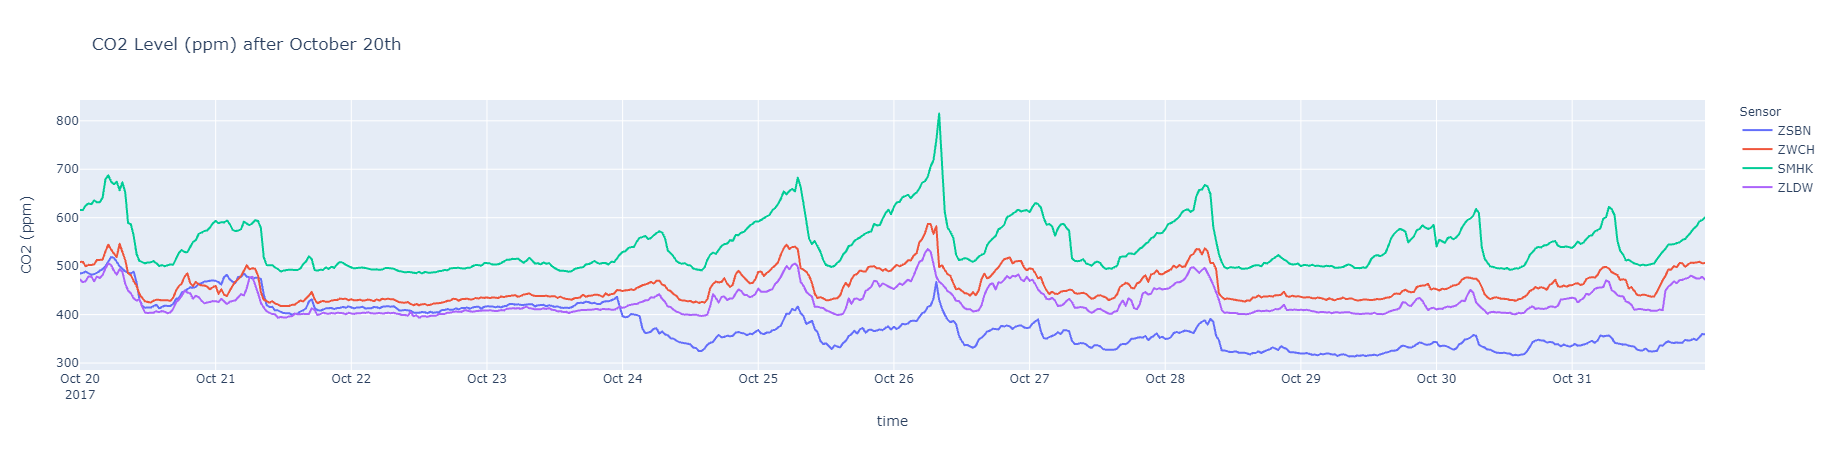

In [66]:
fig = px.line(df_comparison,
              y='CO2',
              color='LocationName',
              labels={
                'timestamp':'time',
                'CO2':'CO2 (ppm)',
                'LocationName':'Sensor'
              }, 
              title='CO2 Level (ppm) after October 20th'
             )
fig.update_xaxes(
    dtick=24*60*60*1000
)
fig.update_layout(
    hovermode='x unified'
)
fig.show()

### b) **8/35**

The domain experts ask you if you could reconstruct the CO2 concentration of the drifting sensor had the drift not happened. You decide to:
- Fit a linear regression model to the CO2 measurements of the site, by considering as features the covariates not affected by the malfunction (such as temperature and humidity)
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

__Note:__ Cross validation on time series is different from that on other kinds of datasets. The following diagram illustrates the series of training sets (in orange) and validation sets (in blue). For more on time series cross validation, there are a lot of interesting articles available online. scikit-learn provides a nice method [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

![ts_cv](https://player.slideplayer.com/86/14062041/slides/slide_28.jpg)

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats
import statsmodels.api as sm

In [68]:
# Dataframe for regression, only ZSBN data is kept, with the unaffected covariates
reg_df = final_df.loc[final_df['LocationName'] == 'ZSBN', ['temperature', 'humidity', 'CO2']]
reg_df['time'] = reg_df.reset_index().index

In [69]:
# Function that performs rolling cross validation and returns the best model (According to MSE)
# and the used training set
def rolling_cross_validation(X, y):
    # split the dataset
    series_split = TimeSeriesSplit(n_splits=50)
    model = LinearRegression()
    min_mse = np.inf
    final_train_ind = None
    # iterate on the different train-test split in order to pick the best model
    for train_indices, test_indices in series_split.split(X):
        train_x, train_y = X[train_indices], y[train_indices]
        test_x, test_y = X[test_indices], y[test_indices]
        model.fit(train_x, train_y)
        mse = mean_squared_error(test_y, model.predict(test_x))
        if mse <= min_mse:
            min_mse = mse
            final_train_ind = train_indices
    return final_train_ind 

In [70]:
# only keep values before OCT 24 for training
X_train = reg_df.loc[reg_df.index.day < 24 , ['temperature', 'humidity', 'time']].values
y_train = reg_df.loc[reg_df.index.day < 24, 'CO2'].values
X_pred = reg_df[['temperature', 'humidity', 'time']].values

In [71]:
X_train

array([[1.11466667e+01, 9.26080170e+01, 0.00000000e+00],
       [1.09150000e+01, 9.22208252e+01, 1.00000000e+00],
       [1.08600000e+01, 9.26620585e+01, 2.00000000e+00],
       ...,
       [7.98500000e+00, 9.16114273e+01, 1.10100000e+03],
       [8.00500000e+00, 9.18339513e+01, 1.10200000e+03],
       [8.04000000e+00, 9.21394450e+01, 1.10300000e+03]])

In [72]:
train_indices = rolling_cross_validation(X_train, y_train)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [73]:
# We use StatsModels in order to compute the 95% CIs
ols = sm.OLS(y_train, sm.add_constant(X_train))
results = ols.fit()
predictions = results.get_prediction(sm.add_constant(X_pred))
conf_intervals =  predictions.conf_int()

In [74]:
reg_df['lower_ci'] = conf_intervals[:, 0]
reg_df['upper_ci'] = conf_intervals[:, 1]
reg_df['predicted'] = predictions.predicted_mean

In [75]:
fig = go.Figure([go.Scatter(x=reg_df.index,
                              y=reg_df['predicted'],
                              mode='lines', name='Predicted'), 
                 go.Scatter(x=reg_df.index,
                            y=reg_df['CO2'],
                            mode='lines', name='Measured'),
                 go.Scatter( x=reg_df.index.append(reg_df.index[::-1]),
                             y=list(reg_df['upper_ci']) + list(reg_df['lower_ci'][::-1]),
                             fill='toself',
                             fillcolor='rgba(0,100,80,0.2)',
                             line=dict(color='rgba(255,255,255,0)'),
                             name='95 % CI')
                 ])

fig.update_xaxes(dtick=24*60*60*1000)
fig.update_layout(hovermode='x unified', title='Measured vs Predicted CO2 levels For ZSBN Sensor in October')
fig.show()

### c) **10/35**

In your next attempt to solve the problem, you decide to exploit the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar.

- Find the sensors sharing similar conditions with `ZSBN`. Explain your definition of "similar condition".
- Fit a linear regression model to the CO2 measurements of the site, by considering as features:
    - the information of provided by similar sensors
    - the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

## Answer

We can consider "similar conditions" as being in close altitude and in close environmental status on average. Hence similar sensors as ZSBN are sensors that are in the same cluster and that have the same temperature and humidity on average as ZSBN. 

In [76]:
final_df.head()

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-01 00:00:00    1014    11.396667  92.440806  595.004391         ZGHD   
2017-10-01 00:30:00    1014    11.303333  91.625097  597.017879         ZGHD   
2017-10-01 01:00:00    1014    11.240000  91.096761  596.487010         ZGHD   
2017-10-01 01:30:00    1014    11.260000  91.275734  598.787639         ZGHD   
2017-10-01 02:00:00    1014    11.285000  91.003937  595.366394         ZGHD   

                     zone  altitude        lat       lon  altitude_cluster  
timestamp                                                                   
2017-10-01 00:00:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 00:30:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 01:00:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 01:30:00     2     413.5  47.370446  8.523256                 0  
2017-10-01 02:00:00     2     413.5  47.370446  8.523256                 0

In [77]:
aver_conditions= final_df.groupby("LocationName").mean()

In [78]:
aver_conditions.head()

sensor  temperature   humidity         CO2  zone  altitude  \
LocationName                                                               
AJGR            1122    11.575974  78.200039  336.112772     2     627.8   
BSCR            1120    10.219236  86.175991  498.038153     2     462.3   
BUDF            1124    11.087855  81.493824  437.373009    10     490.2   
KBRL            1176    12.273949  76.303942  415.482440     7     510.5   
KTGM            1211    12.056663  75.536573  449.240315     2     530.3   

                   lat       lon  altitude_cluster  
LocationName                                        
AJGR          47.33321  8.480300                 1  
BSCR          47.35581  8.430070                 3  
BUDF          47.36270  8.433110                 3  
KBRL          47.32582  8.537550                 3  
KTGM          47.32334  8.596422                 3

In [79]:
result

LocationName  CO2_median  altitude        lat       lon altitude_cluster
0          AJGR  334.785793     627.8  47.333210  8.480300                1
1          BSCR  474.502250     462.3  47.355810  8.430070                3
2          BUDF  422.793126     490.2  47.362700  8.433110                3
3          KBRL  410.100150     510.5  47.325820  8.537550                3
4          KTGM  444.395518     530.3  47.323340  8.596422                3
5          RCTZ  451.003079     440.9  47.434277  8.506933                0
6          SMHK  522.346787     404.4  47.394410  8.445830                0
7          SZGL  488.481426     391.9  47.405815  8.445361                0
8          ULGW  430.143296     627.1  47.357480  8.469090                1
9          UTLI  779.594440     863.6  47.351406  8.490318                2
10         WMOO  432.382187     526.3  47.336250  8.461950                3
11         WRTW  428.965858     451.4  47.418366  8.603844                0
12         WSUM  386.297648     424.7  47.419728  8.430176                0
13         ZALL  469.616355     422.7  47.353400  8.524100                0
14         ZAML  514.683942     445.5  47.424093  8.507078                0
15         ZAZG  448.988224     430.6  47.413577  8.572150                0
16         ZBLG  438.280143     410.7  47.378930  8.512590                0
17         ZBRC  438.016085     436.0  47.425955  8.542861                0
18         ZDLT  444.828444     448.4  47.365820  8.503600                0
19         ZECB  429.376849     406.8  47.383200  8.509864                0
20         ZFBL  467.144218     443.4  47.428260  8.550420                0
21         ZFHB  391.755015     518.5  47.395000  8.551740                3
22         ZFRK  467.852716     442.0  47.409757  8.543918                0
23         ZGHD  614.545051     413.5  47.370446  8.523256                0
24         ZHBG  406.154557     683.9  47.385994  8.568091                1
25         ZHBR  428.127696     615.8  47.381580  8.566050                1
26         ZHRG  439.161697     410.5  47.377773  8.519460                0
27         ZHRO  437.753069     397.6  47.393940  8.486670                0
28         ZHRZ  493.186651     429.5  47.403596  8.587764                0
29         ZLDW  425.401803     405.9  47.348870  8.536290                0
30         ZLMT  440.420556     407.8  47.369230  8.543280                0
31         ZNEU  459.149172     404.7  47.384587  8.525195                0
32         ZORL  481.059336     439.9  47.414780  8.537913                0
33         ZPFW  422.472054     402.5  47.388045  8.513577                0
34         ZPRD  439.426745     409.7  47.370224  8.538994                0
35         ZRDH  348.186164     470.0  47.418554  8.511709                3
36         ZSBN  417.820925     415.4  47.385835  8.477908                0
37         ZSCH  448.509612     413.1  47.370983  8.523569                0
38         ZSEF  450.205149     415.1  47.357170  8.555190                0
39         ZSTA  435.569305     420.8  47.386741  8.539785                0
40         ZSTL  494.296882     430.8  47.408340  8.563520                0
41         ZSZW  460.875583     602.2  47.382488  8.590823                1
42         ZTBN  466.948569     402.9  47.389721  8.517753                0
43         ZUBG  416.204517     480.7  47.352860  8.511080                3
44          ZUE  434.604078     408.8  47.377576  8.530397                0
45         ZWCH  450.098594     450.0  47.343030  8.527060                0

In [80]:
#aver_conditions = pd.merge(aver_conditions.reset_index(), result, on= "LocationName")[["LocationName", "temperature", "humidity", "altitude_cluster"]]
aver_conditions = aver_conditions.reset_index()[["LocationName", "temperature", "humidity", "altitude_cluster"]]

In [81]:
aver_conditions

LocationName  temperature   humidity  altitude_cluster
0          AJGR    11.575974  78.200039                 1
1          BSCR    10.219236  86.175991                 3
2          BUDF    11.087855  81.493824                 3
3          KBRL    12.273949  76.303942                 3
4          KTGM    12.056663  75.536573                 3
5          RCTZ    11.302966  83.057318                 0
6          SMHK    11.565501  81.593835                 0
7          SZGL    11.792489  80.169048                 0
8          ULGW    11.465651  78.719270                 1
9          UTLI    10.951177  77.305900                 2
10         WMOO    10.511334  82.544410                 3
11         WRTW    11.899327  79.781732                 0
12         WSUM    12.184343  78.501201                 0
13         ZALL    11.693108  80.123963                 0
14         ZAML    11.434867  80.607734                 0
15         ZAZG    11.031657  82.853222                 0
16         ZBLG    12.161991  76.014960                 0
17         ZBRC    11.555451  79.317884                 0
18         ZDLT    11.995130  79.771981                 0
19         ZECB    12.043794  78.620975                 0
20         ZFBL    11.484794  80.403736                 0
21         ZFHB    11.230503  81.978645                 3
22         ZFRK    12.842060  73.583327                 0
23         ZGHD    12.611603  76.143292                 0
24         ZHBG    11.315282  79.944218                 1
25         ZHBR    12.390614  75.522454                 1
26         ZHRG    12.417935  75.818840                 0
27         ZHRO    10.585045  78.231609                 0
28         ZHRZ    11.239105  80.739265                 0
29         ZLDW    12.756658  75.304742                 0
30         ZLMT    13.486093  72.467793                 0
31         ZNEU    13.535243  71.424089                 0
32         ZORL    11.981051  77.292830                 0
33         ZPFW    10.797397  75.410526                 0
34         ZPRD    13.060351  71.559350                 0
35         ZRDH    11.475410  81.342080                 3
36         ZSBN    11.970552  80.856915                 0
37         ZSCH    12.587888  75.331439                 0
38         ZSEF    12.837119  74.263122                 0
39         ZSTA    13.620859  69.393720                 0
40         ZSTL    11.349153  82.289257                 0
41         ZSZW    11.310095  79.609529                 1
42         ZTBN    12.203694  77.792331                 0
43         ZUBG    11.524243  78.355152                 3
44          ZUE    12.702162  74.072489                 0
45         ZWCH    12.001071  77.919138                 0

In [82]:
# extracting the cluster of ZSBN sensor
zsbn_cluster = aver_conditions[aver_conditions.LocationName == "ZSBN"].altitude_cluster.iloc[0]

In [83]:
# taking only sensors in the same cluster as ZSBN
aver_conditions = aver_conditions[aver_conditions.altitude_cluster == zsbn_cluster]

In [84]:
aver_conditions.head()

LocationName  temperature   humidity  altitude_cluster
5          RCTZ    11.302966  83.057318                 0
6          SMHK    11.565501  81.593835                 0
7          SZGL    11.792489  80.169048                 0
11         WRTW    11.899327  79.781732                 0
12         WSUM    12.184343  78.501201                 0

In [85]:
# Extracting average humidity and average temperature of ZSBN sensor
zsbn_humidity = aver_conditions[aver_conditions.LocationName == "ZSBN"]["humidity"].iloc[0]
zsbn_temp = aver_conditions[aver_conditions.LocationName == "ZSBN"]["temperature"].iloc[0]

In [86]:
# extracting similar sensors. Here the choice of the constants can be changed
similar = aver_conditions.loc[(np.abs(aver_conditions.temperature - zsbn_temp) <= 0.5) & (np.abs(aver_conditions.humidity - zsbn_humidity) <= 1) ]

In [87]:
# extracting the location name of the sensors as a set
similar_sensors = set(similar[similar["LocationName"] != "ZSBN"].LocationName.values)

In [88]:
similar_sensors

{'SMHK', 'SZGL', 'ZALL', 'ZFBL'}

In [89]:
features = final_df[final_df.LocationName == "ZSBN"][["temperature", "humidity"]]

In [90]:
features.head()

temperature   humidity
timestamp                                  
2017-10-01 00:00:00    11.146667  92.608017
2017-10-01 00:30:00    10.915000  92.220825
2017-10-01 01:00:00    10.860000  92.662059
2017-10-01 01:30:00    10.820000  92.934809
2017-10-01 02:00:00    10.760000  93.407832

In [91]:
X = np.array(features)

In [92]:
X.shape

(1488, 2)

In [93]:
# constructing the feature vector i.e [ZSBN_temperature, ZSBN_humidity, CO2_measurements_of_similar_sensors]
for sensor in similar_sensors:
    t = final_df[final_df.LocationName == sensor]["CO2"]
    t = np.array(t).reshape(-1,1)
    X = np.concatenate((X, t), axis=1)

In [94]:
X.shape

(1488, 6)

In [95]:
# constructing the target vector : CO2 measurement of the faulty sensor ZSBN
Y= np.array(final_df[final_df.LocationName == "ZSBN"]["CO2"]).reshape(-1,1)

In [96]:
Y.shape

(1488, 1)

In [97]:
# fit linear regression model
model= LinearRegression()
model.fit(X, Y)

LinearRegression()

In [98]:
features["actual_CO2"]= final_df[final_df.LocationName == "ZSBN"]["CO2"]

In [99]:
features["predicted_CO2"]= model.predict(X)

### d) **10/35**

Now, instead of feeding the model with all features, you want to do something smarter by using linear regression with fewer features.

- Start with the same sensors and features as in question c)
- Leverage at least two different feature selection methods
- Create similar interactive plot as in question c)
- Describe the methods you choose and report your findings

## First Feature selection method: Univariate selection based on F-score

One way to select the most relevant features is by using Univariate selection. The method consists of computing the correlation between each feature and the target variable (Here, the CO2 measurement). We then keep the most k correlated features.
This approach detects only linear relationship between the covariate and the target.

In [100]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

In [101]:
s= final_df[final_df.LocationName.isin(similar_sensors)]

In [102]:
similar_sensors = list(similar_sensors)

In [103]:
before_24= s[s.index < "2017-10-24"]

In [104]:
before_24.head()

sensor  temperature   humidity         CO2 LocationName  \
timestamp                                                                      
2017-10-01 00:00:00    1035    10.376667  92.005295  445.905382         ZFBL   
2017-10-01 00:30:00    1035    10.353333  92.896027  448.274248         ZFBL   
2017-10-01 01:00:00    1035    10.373333  93.082947  451.841394         ZFBL   
2017-10-01 01:30:00    1035    10.320000  93.176407  449.712983         ZFBL   
2017-10-01 02:00:00    1035    10.246667  93.190394  455.367638         ZFBL   

                     zone  altitude       lat      lon  altitude_cluster  
timestamp                                                                 
2017-10-01 00:00:00     5     443.4  47.42826  8.55042                 0  
2017-10-01 00:30:00     5     443.4  47.42826  8.55042                 0  
2017-10-01 01:00:00     5     443.4  47.42826  8.55042                 0  
2017-10-01 01:30:00     5     443.4  47.42826  8.55042                 0  
2017-10-01 02:00:00     5     443.4  47.42826  8.55042                 0

In [105]:
zsbn_before_24= final_df.loc[(final_df.LocationName == "ZSBN") & (final_df.index < "2017-10-24") ]

In [106]:
# 
predict_df = final_df[final_df.LocationName == "ZSBN"][["temperature" , "humidity" ,"CO2"]]

In [107]:
X_train = np.array(zsbn_before_24[["temperature", "humidity"]])

In [108]:
X_train.shape

(1104, 2)

In [109]:
for sensor in similar_sensors:
    t = before_24[before_24.LocationName == sensor]["CO2"]
    t = np.array(t).reshape(-1,1)
    X_train = np.concatenate((X_train, t), axis=1)

In [110]:
X_train.shape

(1104, 6)

In [111]:
y_train = np.array(zsbn_before_24["CO2"]).reshape(-1, 1)

In [112]:
y_train.shape

(1104, 1)

In [113]:
# declare the feature selector, here we select the best 2 features
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train.ravel())

# We retrieve the index of the best features
best_features = np.where(selector.get_support())[0]
best_features

array([4, 5])

In [114]:
# retrieve the relevant features
X_train = X_train[:, best_features]

In [115]:
train_indices = rolling_cross_validation(X_train, y_train)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [120]:
X_pred = np.array(predict_df[["temperature", "humidity"]])
for sensor in similar_sensors:
    t = final_df[final_df.LocationName == sensor]["CO2"]
    t = np.array(t).reshape(-1,1)
    X_pred = np.concatenate((X_pred, t), axis=1)

#select the relevant features     
X_pred = X_pred[:, best_features]

In [121]:
X_pred.shape

(1488, 2)

In [122]:
# We use StatsModels in order to compute the 95% CIs
ols = sm.OLS(y_train, sm.add_constant(X_train))
results = ols.fit()
predictions = results.get_prediction(sm.add_constant(X_pred))
conf_intervals =  predictions.conf_int()

In [123]:
# saving the predictions and the confidence interval boundaries in the dataframe
predict_df['lower_ci'] = conf_intervals[:, 0]
predict_df['upper_ci'] = conf_intervals[:, 1]
predict_df['predicted'] = predictions.predicted_mean

In [124]:
predict_df

temperature   humidity         CO2    lower_ci  \
timestamp                                                             
2017-10-01 00:00:00    11.146667  92.608017  418.493079  419.303469   
2017-10-01 00:30:00    10.915000  92.220825  418.169200  420.512062   
2017-10-01 01:00:00    10.860000  92.662059  421.749522  423.244842   
2017-10-01 01:30:00    10.820000  92.934809  424.363039  422.704515   
2017-10-01 02:00:00    10.760000  93.407832  423.172512  426.029281   
...                          ...        ...         ...         ...   
2017-10-31 21:30:00     1.970000  87.830109  350.086494  469.154269   
2017-10-31 22:00:00     1.740000  88.856262  347.270370  477.221936   
2017-10-31 22:30:00     1.581667  89.690409  352.799019  477.701661   
2017-10-31 23:00:00     1.416667  90.499125  360.011709  479.849663   
2017-10-31 23:30:00     1.263333  91.244263  358.835422  475.063267   

                       upper_ci   predicted  
timestamp                                    
2017-10-01 00:00:00  421.475567  420.389518  
2017-10-01 00:30:00  422.647723  421.579893  
2017-10-01 01:00:00  425.328348  424.286595  
2017-10-01 01:30:00  424.831021  423.767768  
2017-10-01 02:00:00  428.089502  427.059392  
...                         ...         ...  
2017-10-31 21:30:00  471.838964  470.496616  
2017-10-31 22:00:00  480.044866  478.633401  
2017-10-31 22:30:00  480.844630  479.273145  
2017-10-31 23:00:00  482.939817  481.394740  
2017-10-31 23:30:00  477.723838  476.393553  

[1488 rows x 6 columns]

In [125]:
# plot the results
fig = go.Figure([go.Scatter(x=predict_df.index,
                              y=predict_df['predicted'],
                              mode='lines', name='Predicted'), 
                 go.Scatter(x=predict_df.index,
                            y=predict_df['CO2'],
                            mode='lines', name='Measured'),
                 go.Scatter( x=predict_df.index.append(predict_df.index[::-1]),
                             y=list(predict_df['upper_ci']) + list(predict_df['lower_ci'][::-1]),
                             fill='toself',
                             fillcolor='rgba(0,100,80,0.2)',
                             line=dict(color='rgba(255,255,255,0)'),
                             name='95 % CI')
                 ])

fig.update_xaxes(dtick=24*60*60*1000)
fig.update_layout(hovermode='x unified', title='Measured vs Predicted CO2 levels For ZSBN Sensor in October (with feature selection)')
fig.show()

## Second Feature selection method: Recursive feature elimination

In [126]:
from sklearn.feature_selection import RFE

In [128]:
ols = sm.OLS(y_train, sm.add_constant(X_train))

In [129]:
rfe = RFE(estimator=ols, n_features_to_select=2, step=1)

In [ ]:
# 

In [ ]:
# We retrieve the index of the best features
best_features = np.where(selector.get_support())[0]
best_features

### e) **5/35**

Eventually, you'd like to try something new - __Bayesian Structural Time Series Modelling__ - to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 24. You will use:
- the information of provided by similar sensors - the ones you identified in question c)
- the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.

- Report your findings:
    - Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?
    - Can you try to explain the results?

In [ ]:
from causalimpact import CausalImpact

In [ ]:
d = final_df[final_df.LocationName == 'ZSBN'][['CO2','temperature','humidity']]
d.head()

In [ ]:
similar_df = final_df[final_df.LocationName.isin(similar_sensors)][['CO2','LocationName','temperature','humidity']]
similar_df.head()

In [ ]:
cols = list(d.columns)
[cols.append(x) for x in similar_df.LocationName.unique()]
cols

In [ ]:
observations = d.join(similar_df.pivot(columns='LocationName', values='CO2'))[cols]
observations.head()

In [ ]:
ci = CausalImpact(observations,
                  ['2017-10-01 00:00:00', '2017-10-23 23:30:00'],
                  ['2017-10-24 00:00:00', '2017-10-31 23:30:00'])

In [ ]:
ci.plot(figsize=(20, 15))

In [ ]:
report = ci.summary(output='report').replace('an\nintervention', 'a\nfailure').replace('intervention', 'failure')
print(report)

# That's all, folks!